In [2]:
%load_ext autoreload
%autoreload 2

In [307]:
import os
import pickle
import sys
from pathlib import Path

import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots
from collections import defaultdict
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)

matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots

from tueplots import bundles, fontsizes, figsizes


from wbml import plot

### Locations

In [308]:
img_folder = 'tmp_imgs'

In [309]:
########### READ LOG FILES ###########

main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
res_dir = os.path.join(main_dir, f"draft_results/")

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
logs = infinite_defaultdict()

# Column headers
pvi_name = "PVI"
variational_name = "Method"
client_name = "Client"
split_name = "Split"
dataset_name = 'Dataset'
experiment_name ='Experiment name'
num_clients_name = 'Number of clients'

exclude = ["draft_results/Credit/Sync/A/07-24-20.54.26_sync-pvi-credit-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m",
            "draft_results/Bank/Sync/A/07-24-14.47.22_sync-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m", 
            "draft_results/Adult/Sync/A/07-24-12.41.02_sync-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m"]

for dataset_type in os.listdir(res_dir):
    for pvi_type in os.listdir(os.path.join(res_dir, dataset_type)):
        for split_type in os.listdir(os.path.join(res_dir, dataset_type, pvi_type)):
            
            exp_dir = os.path.join(res_dir, dataset_type, pvi_type, split_type)
            if len(os.listdir(exp_dir)) > 2:
                print(f"Multiple experiments encountered in {exp_dir}")

            for exp in os.listdir(exp_dir):

                q_type = exp.split('_')[1].split('-')[1]
                num_clients = int(exp.split('_')[1].split('-')[3].split('c')[0])

                # Erroneous file naming
                if q_type == 'pvi': q_type = 'gi'
                
                metrics_dir = os.path.join(exp_dir, exp, "metrics")
                _exp_name = '-'.join(exp.split('_')[1:])
                
                # Exclude experiments in array
                if exp not in exclude:
                    for log_name in os.listdir(metrics_dir):
                        name = log_name.split('_')[0]
                        logs[dataset_type][pvi_type][split_type][q_type][name] = pd.read_csv(os.path.join(metrics_dir, log_name))

                        # Add column values
                        logs[dataset_type][pvi_type][split_type][q_type][name][pvi_name] = pvi_type.upper()
                        logs[dataset_type][pvi_type][split_type][q_type][name][variational_name] = q_type.upper()
                        logs[dataset_type][pvi_type][split_type][q_type][name][split_name] = split_type.upper()
                        logs[dataset_type][pvi_type][split_type][q_type][name][dataset_name] = dataset_type
                        if name != 'server':
                            logs[dataset_type][pvi_type][split_type][q_type][name][client_name] = name
                        logs[dataset_type][pvi_type][split_type][q_type][name][num_clients_name] = num_clients
                        logs[dataset_type][pvi_type][split_type][q_type][name][experiment_name] = _exp_name

Multiple experiments encountered in /Users/maxbronckers/Downloads/GI-PVI/draft_results/Credit/Sync/A
Multiple experiments encountered in /Users/maxbronckers/Downloads/GI-PVI/draft_results/Bank/Sync/A
Multiple experiments encountered in /Users/maxbronckers/Downloads/GI-PVI/draft_results/Adult/Sync/A


Merge dataframes for plotting purposes.

In [310]:
clients = []
for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for name, log in dddd.items():
                    if name != 'server': clients.append(log)

client = pd.concat(clients, ignore_index=True)

In [311]:
servers = []

for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for name, log in dddd.items():
                    if name == 'server': servers.append(log)

server = pd.concat(servers, ignore_index=True)

# Plotting

test mll

In [312]:
server.loc[server[dataset_name] == dataset]

,communications,iteration,train_mll,train_acc,test_mll,test_acc,PVI,Method,Split,Dataset,Number of clients,Experiment name
714,0,0,-0.563856,0.751849,-0.563540,0.745291,SEQ,GI,A,Adult,10,seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-0...
715,2,1,-0.546790,0.764697,-0.549947,0.755119,SEQ,GI,A,Adult,10,seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-0...
716,4,2,-0.553621,0.760372,-0.558499,0.755528,SEQ,GI,A,Adult,10,seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-0...
717,6,3,-0.543731,0.765439,-0.546101,0.760238,SEQ,GI,A,Adult,10,seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-0...
718,8,4,-0.543687,0.764722,-0.547821,0.759418,SEQ,GI,A,Adult,10,seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-0...
...,...,...,...,...,...,...,...,...,...,...,...,...
1168,120,6,-0.362181,0.829166,-0.370902,0.824324,SYNC,GI,B,Adult,10,sync-pvi-adult-10c-10g-2000l-nealprior-splitb-...
1169,140,7,-0.623802,0.775548,-0.634875,0.771908,SYNC,GI,B,Adult,10,sync-pvi-adult-10c-10g-2000l-nealprior-splitb-...
1170,160,8,-0.391192,0.792798,-0.397705,0.789210,SYNC,GI,B,Adult,10,sync-pvi-adult-10c-10g-2000l-nealprior-splitb-...
1171,180,9,-0.653994,0.788396,-0.676516,0.783989,SYNC,GI,B,Adult,10,sync-pvi-adult-10c-10g-2000l-nealprior-splitb-...


In [313]:
dataset = "Bank"
split = "A"
omit_sync_mfvi = True
save_plot = False

data = server.loc[server[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'communications'])

# Check whether these are the experiments you want to plot.
pd.unique(data[experiment_name])

array(['seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m',
       'seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m',
       'sync-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m',
       'seq-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s',
       'seq-mfvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi'],
      dtype=object)

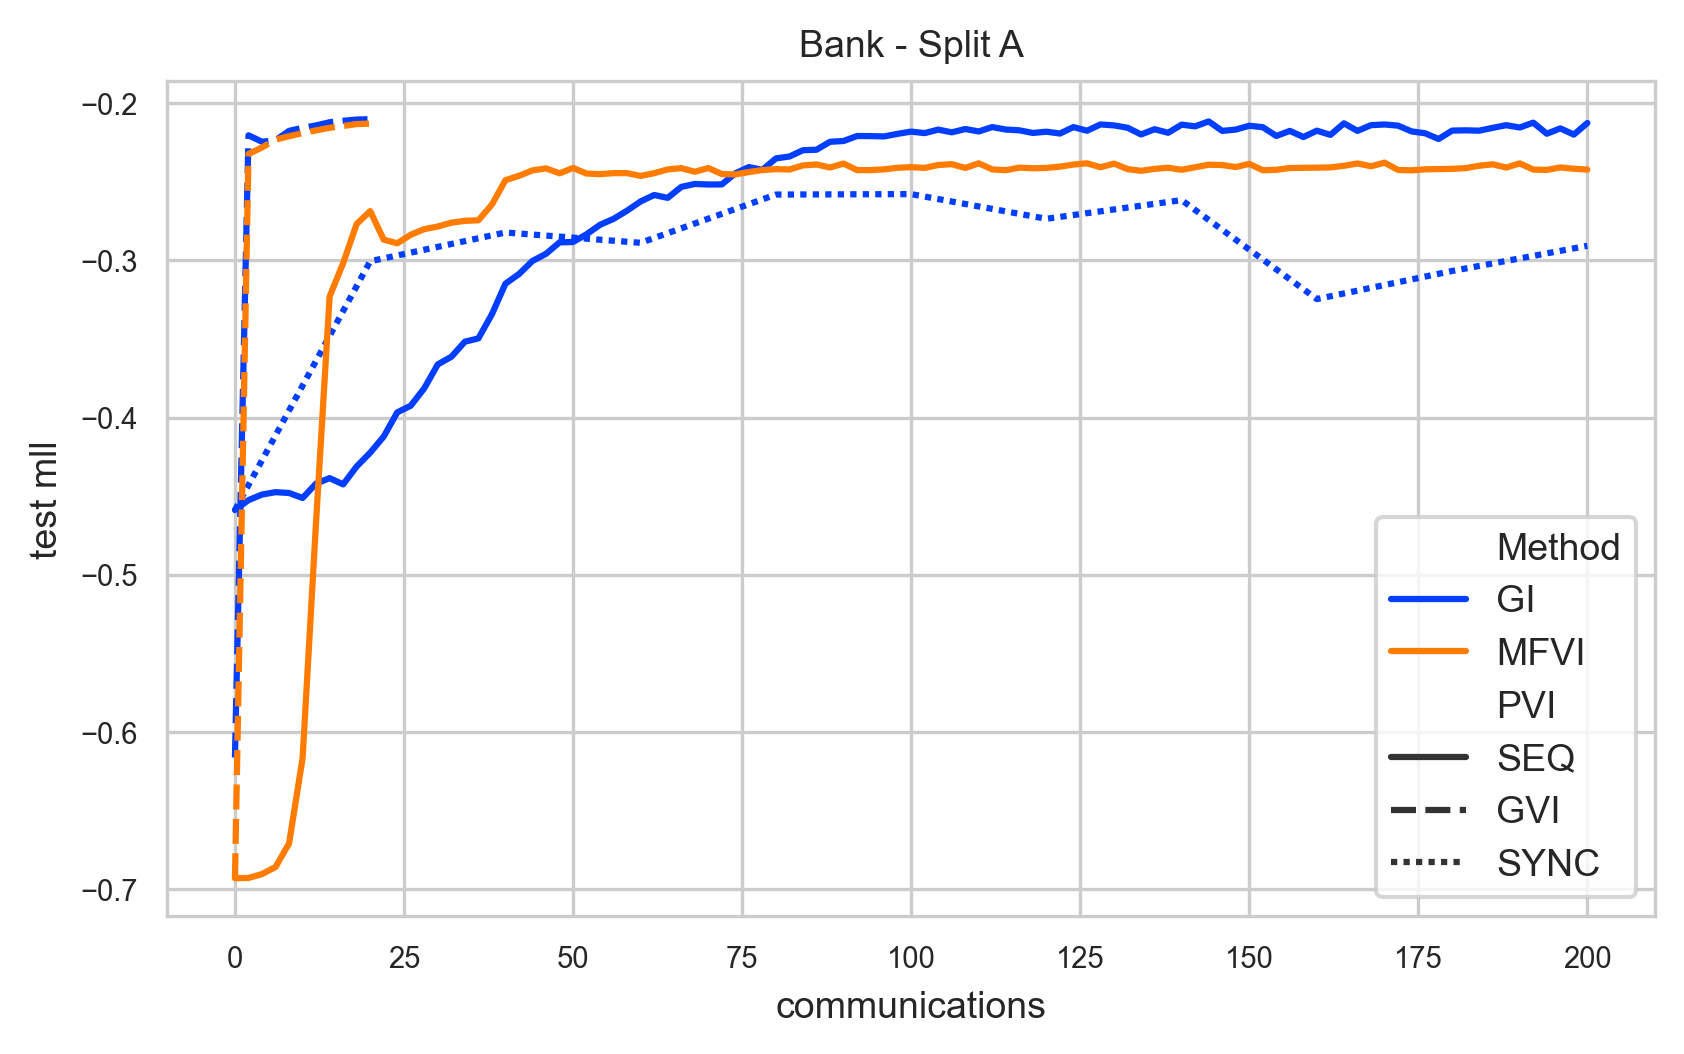

In [304]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    x_metric = 'communications'
    y_metric = 'test_mll'
    
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{split}_{dataset}_server_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    if save_plot: plt.savefig(file_name)
    plt.show()

Accuracy

In [314]:
dataset = "Adult"
split = "A"
omit_sync_mfvi = True
save_plot = False

data = server.loc[server[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'communications'])

# Check whether these are the experiments you want to plot.
pd.unique(data[experiment_name])

array(['seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight',
       'seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi',
       'sync-pvi-adult-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l',
       'seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi',
       'sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi'],
      dtype=object)

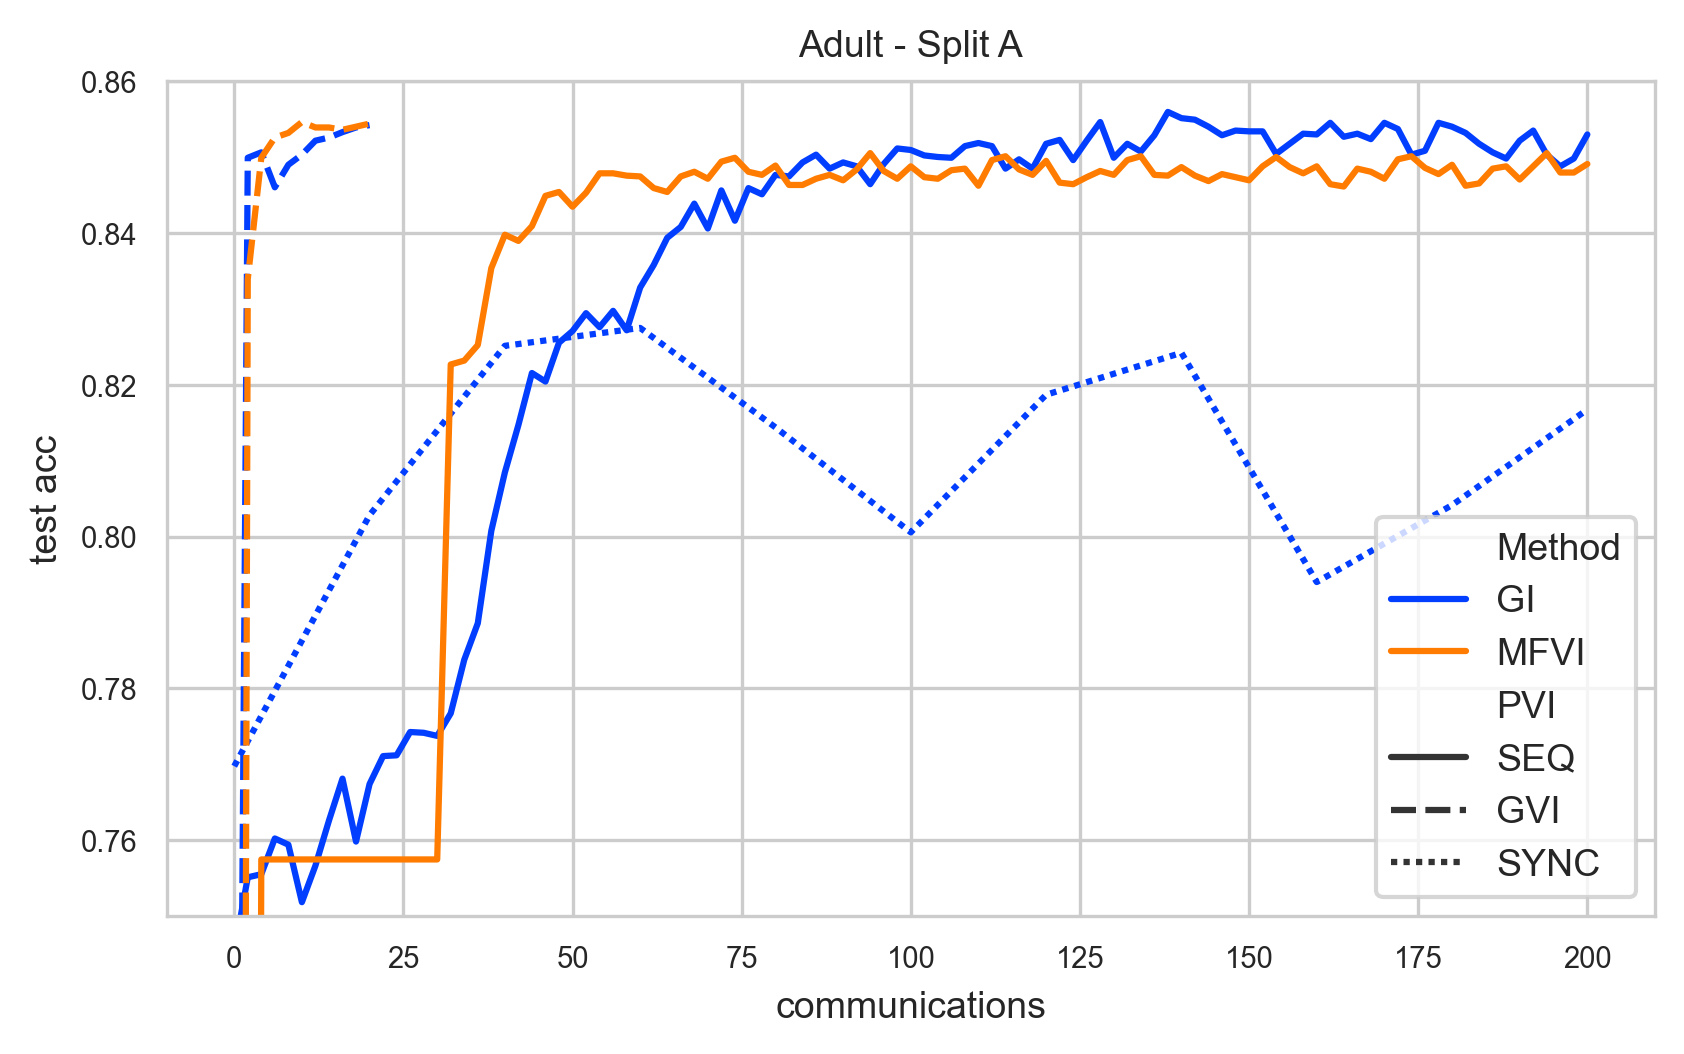

In [306]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    x_metric = 'communications'
    y_metric = 'test_acc'
    
    sns.lineplot(data=data.loc[data[dataset_name] == dataset], x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{split}_{dataset}_server_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"


    if dataset.lower() == 'bank':
        ylim=(0.85, 0.91)
        ax.set_ylim(ylim)
    elif dataset.lower() == 'adult':
        ylim=(0.75, 0.86)
        ax.set_ylim(ylim)

    if save_plot: plt.savefig(file_name)
    plt.show()

    

### Client

In [145]:
client

,global_iteration,local_iteration,total_iteration,vfe,ll,kl,error,PVI,Method,Client
0,4,0,4000,-6.236976,-0.679725,20095.017578,0.132812,SEQ,MFVI,client4
1,4,49,4049,-6.161118,-0.678115,19826.537109,0.156250,SEQ,MFVI,client4
2,4,99,4099,-6.130808,-0.673799,19732.544922,0.093750,SEQ,MFVI,client4
3,4,149,4149,-6.118912,-0.673064,19692.185547,0.101562,SEQ,MFVI,client4
4,4,199,4199,-6.114376,-0.674430,19670.843750,0.140625,SEQ,MFVI,client4
...,...,...,...,...,...,...,...,...,...,...
8815,9,799,9799,-0.161379,-0.144709,602.917664,0.054688,GVI,GI,client0
8816,9,849,9849,-0.290775,-0.274702,581.320312,0.101562,GVI,GI,client0
8817,9,899,9899,-0.228825,-0.212784,580.175903,0.117188,GVI,GI,client0
8818,9,949,9949,-0.177203,-0.160438,606.353760,0.070312,GVI,GI,client0


In [315]:
dataset = "Adult"
split = "A"
omit_sync_mfvi = True
save_plot = False

data = client.loc[client[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'total_iteration'])

# Check whether these are the experiments you want to plot.
pd.unique(data[experiment_name])

array(['seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight',
       'seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi',
       'sync-pvi-adult-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l',
       'seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi',
       'sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi'],
      dtype=object)

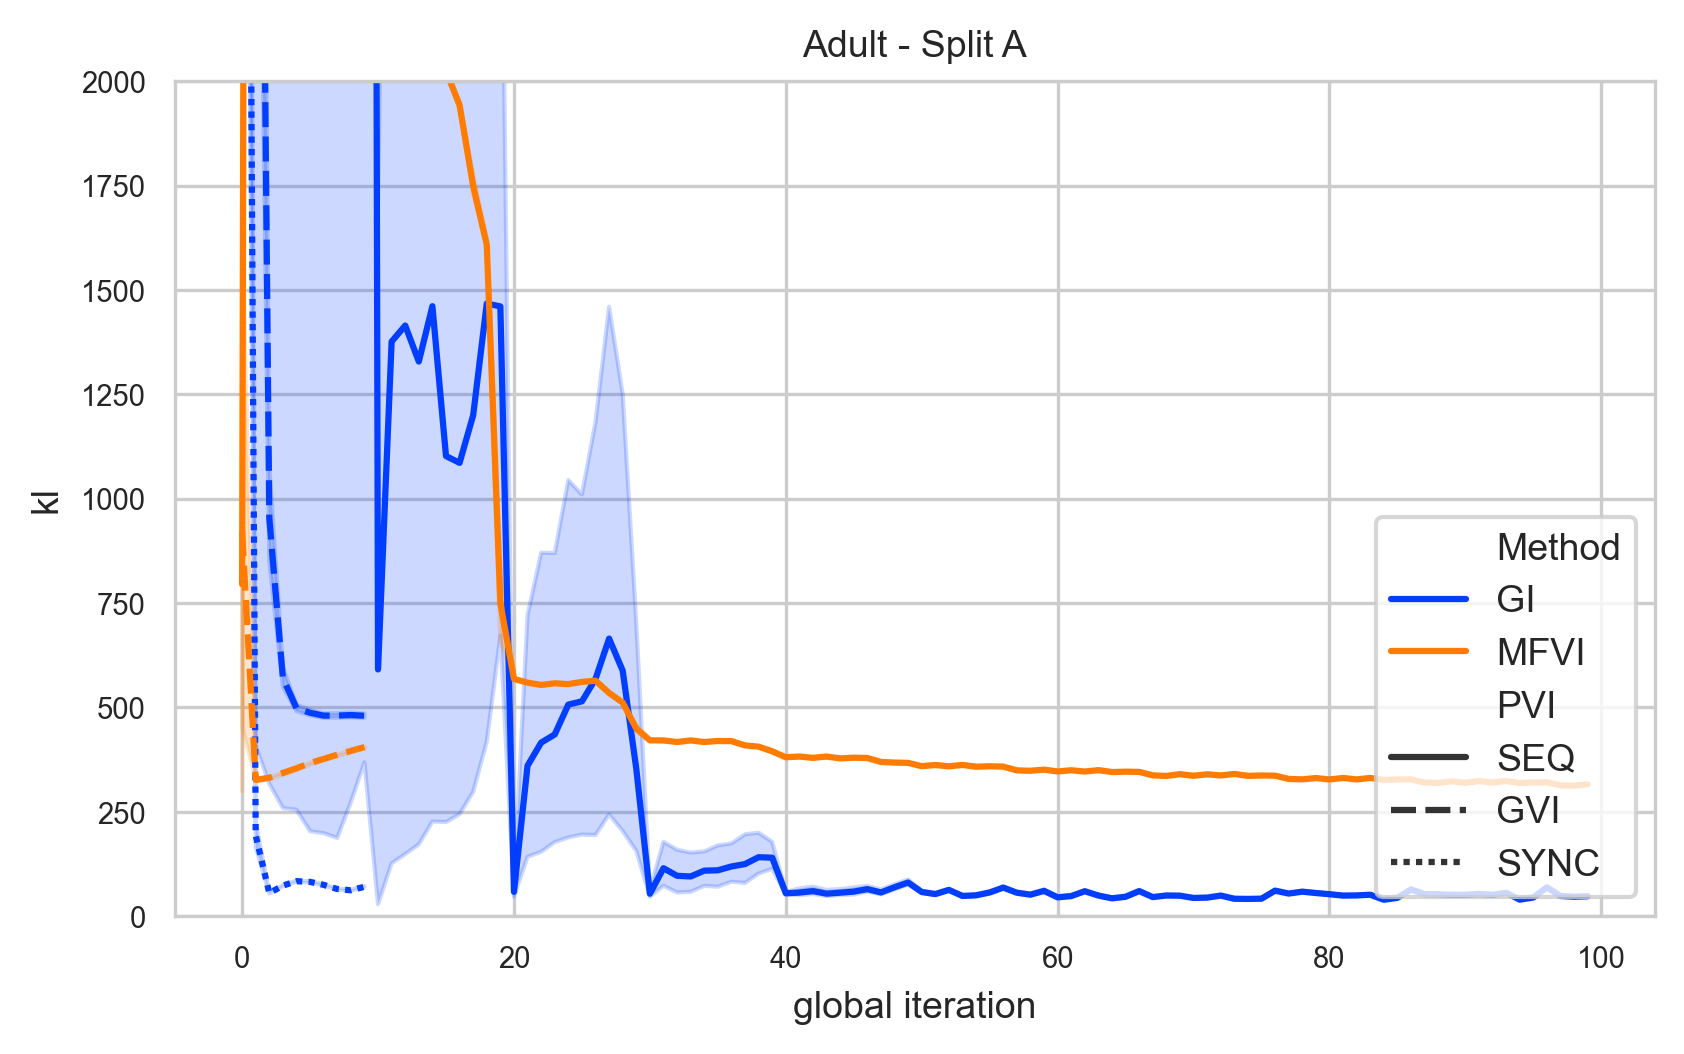

In [321]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    y_metric = "kl"
    x_metric = "global_iteration"
    
    sns.lineplot(data=data.loc[data[dataset_name] == dataset], x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    ax.set_ylim(0, 2000)

    file_name = f"./{img_folder}/{split}_{dataset}_client_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    if save_plot: plt.savefig(file_name)
    plt.show()
